# Quiz/Hands-on: Analyzing airline tweets using NLP

In [1]:
from typing import List, Iterable
from datetime import datetime
import pandas as pd
import re

import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/TL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

In [3]:
df = pd.read_csv("../resources/airline_tweets.csv")
df

,tweet_id,airline,handle,text,tweet_created,user_timezone
0,570306133677760000,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2/24/15 11:35,Eastern Time (US & Canada)
1,570301130888122000,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2/24/15 11:15,Pacific Time (US & Canada)
2,570301083672813000,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2/24/15 11:15,Central Time (US & Canada)
3,570301031407624000,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2/24/15 11:15,Pacific Time (US & Canada)
4,570300817074462000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2/24/15 11:14,Pacific Time (US & Canada)
...,...,...,...,...,...,...
14635,569587686496825000,American,KristenReenders,@AmericanAir thank you we got on a different f...,2/22/15 12:01,NaN
14636,569587371693355000,American,itsropes,@AmericanAir leaving over 20 minutes Late Flig...,2/22/15 11:59,NaN
14637,569587242672398000,American,sanyabun,@AmericanAir Please bring American Airlines to...,2/22/15 11:59,NaN
14638,569587188687634000,American,SraJackson,"@AmericanAir you have my money, you change my ...",2/22/15 11:59,Eastern Time (US & Canada)


The dataset consists of tweets on airline experiences.

After looking it up online, the dataset seems to be a shortened version of the <a href="https://www.kaggle.com/crowdflower/twitter-airline-sentiment">twitter airline sentiment</a> dataset, available on kaggle or crowdflower.

According to the kaggle page,

> A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


# Goal

For this dataset, I wish to figure out people's sentiments towards the different airlines mentioned in the tweets. I want to know the underlying reasons behind those sentiments. What is it about some airlines that people like or dislike?

I chose this as the goal since it has some real life merit. Knowing this may be useful so airlines know which aspects they can improve in, and for passengers to know what they may expect when going with a particular airline.

# Methods

In order to fulfill the goals mentioned above, the following steps will be taken:

1. **Prepare the data.**
2. **Identify the different airlines mentioned in the dataset.**
3. **Group together tweets according to airline and find the sentiment for each group.**
4. **Attempt to identify the reasons for the sentiments.**

## Data Preparation
### Text Cleaning
It is best practice to maintain two forms of text, for context-aware and word-level tasks.

**Context Aware Tasks**<br>
For this, we remove:
* Special characters
    * Except punctuations at the end of a sentence, which is important for dependency parsing.
* leading and trailing whitespaces
* Twitter handles
* hashtags

**Word-level Tasks:**<br>
Same as above, but additionally: 
* lowercased
* lemmatized
* stopword-removed
* special characters removed

We also keep the text in its original form.

In [12]:
from nltk.stem import WordNetLemmatizer

class TextCleaner:
    """Cleaning functions."""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop = set(stopwords.words("english"))
        
    def clean_context_aware(self, text: str) -> str:
        """Clean text for context-level analysis."""

        # Remove the ff:
        # Twitter handles and hashtags
        text = re.sub("[#@][\w]+", "", text)

        # Special characters (except sentence endings)
        text = re.sub("[^\w?!\.,\s]+", "", text)

        # Extra spaces
        text = re.sub("\s+", " ", text)  # Multiple consecutive spaces
        text = re.sub("\s\.", ".", text)  # Space before period
        text = text.strip()  # Leading and trailing whitespaces

        return text
        
    def clean_word_level(self, text: str) -> str:
        """Clean text for word-level analysis."""
        text = self.clean_context_aware(text)
        # lowercase
        text = text.lower()
        # remove all special chars
        text = re.sub("[^A-Za-z0-9\s]+", "", text)
        # remove stopwords and lemmatize
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stop]
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return ' '.join(tokens)

In [13]:
cleaner = TextCleaner()
df['text_context'] = df['text'].map(cleaner.clean_context_aware)
df['text_word'] = df['text'].map(cleaner.clean_word_level)
df[['text', 'text_context', 'text_word']]

,text,text_context,text_word
0,@VirginAmerica What @dhepburn said.,What said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,I didnt today... Must mean I need to take anot...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,really big bad thing
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,thank you we got on a different flight to Chic...,thank got different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes Late Flight. No warnin...,leaving 20 minute late flight warning communic...
14637,@AmericanAir Please bring American Airlines to...,Please bring American Airlines to,please bring american airline
14638,"@AmericanAir you have my money, you change my ...","you have my money, you change my flight, and d...",money change flight dont answer phone suggesti...


In [15]:
context_aware_df = df.copy()
context_aware_df['text'].map(cleaner.clean_context_aware)
context_aware_df

,tweet_id,airline,handle,text,tweet_created,user_timezone,text_context,text_word
0,570306133677760000,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2/24/15 11:35,Eastern Time (US & Canada),What said.,said
1,570301130888122000,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2/24/15 11:15,Pacific Time (US & Canada),plus youve added commercials to the experience...,plus youve added commercial experience tacky
2,570301083672813000,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2/24/15 11:15,Central Time (US & Canada),I didnt today... Must mean I need to take anot...,didnt today must mean need take another trip
3,570301031407624000,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2/24/15 11:15,Pacific Time (US & Canada),its really aggressive to blast obnoxious enter...,really aggressive blast obnoxious entertainmen...
4,570300817074462000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2/24/15 11:14,Pacific Time (US & Canada),and its a really big bad thing about it,really big bad thing
...,...,...,...,...,...,...,...,...
14635,569587686496825000,American,KristenReenders,@AmericanAir thank you we got on a different f...,2/22/15 12:01,NaN,thank you we got on a different flight to Chic...,thank got different flight chicago
14636,569587371693355000,American,itsropes,@AmericanAir leaving over 20 minutes Late Flig...,2/22/15 11:59,NaN,leaving over 20 minutes Late Flight. No warnin...,leaving 20 minute late flight warning communic...
14637,569587242672398000,American,sanyabun,@AmericanAir Please bring American Airlines to...,2/22/15 11:59,NaN,Please bring American Airlines to,please bring american airline
14638,569587188687634000,American,SraJackson,"@AmericanAir you have my money, you change my ...",2/22/15 11:59,Eastern Time (US & Canada),"you have my money, you change my flight, and d...",money change flight dont answer phone suggesti...


In [16]:
cleaner = TextCleaner()
context_aware_df = df.copy()
context_aware_df['text']
word_level_df = df.copy()

# Data Exploration / Findings

## Identifying Airlines

I know that the data is composed of tweets on different airlines. However, I do not know which specific airlines these are. I will try to find this out in the next section by checking the twitter handles mentioned in the text.

In [17]:
# Get twitter handles and the number of mentions
twitter_handles_freq = {}
tw_handle_regex = re.compile("@[\w]+")

for text in df['text']:
    for handle in tw_handle_regex.findall(text):
        handle = handle.lower()
        twitter_handles_freq[handle] = twitter_handles_freq.get(handle, 0) + 1
        
# To get only airlines
# Remove handles mentioned < 100 times
airlines = {k:v for k, v in twitter_handles_freq.items() if v >= 100}
airlines

{'@virginamerica': 519,
 '@southwestair': 2458,
 '@jetblue': 2248,
 '@united': 3894,
 '@americanair': 2961,
 '@usairways': 3000}

We then create a frequency graph to see the distribution of airline tweets in the corpus. 

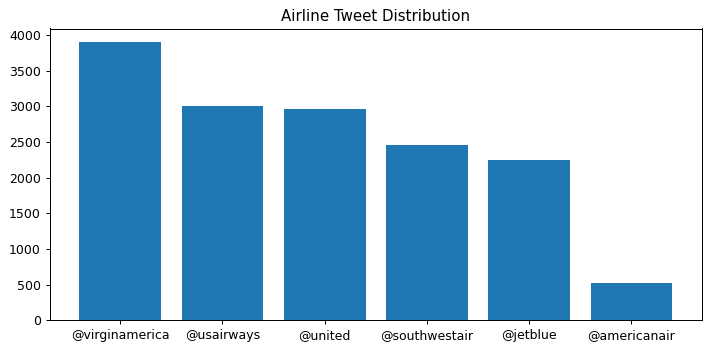

In [18]:
fig, ax = plt.subplots(figsize=(8,4), dpi=90)
x = sorted(airlines.keys(), reverse=True)
y = sorted(airlines.values(), reverse=True)
ax.bar(x, y)
ax.set_title("Airline Tweet Distribution")
plt.tight_layout()

It seems that there are 6 main airlines featured in the dataset.

## Date Distribution

According to the original source, the tweets were taken from a time interval in February 2015. I want to confirm this, and further see the distribution of tweets in that month. I also want to see if there were any significant events that happened in that time period which may affect the contents of the tweets.

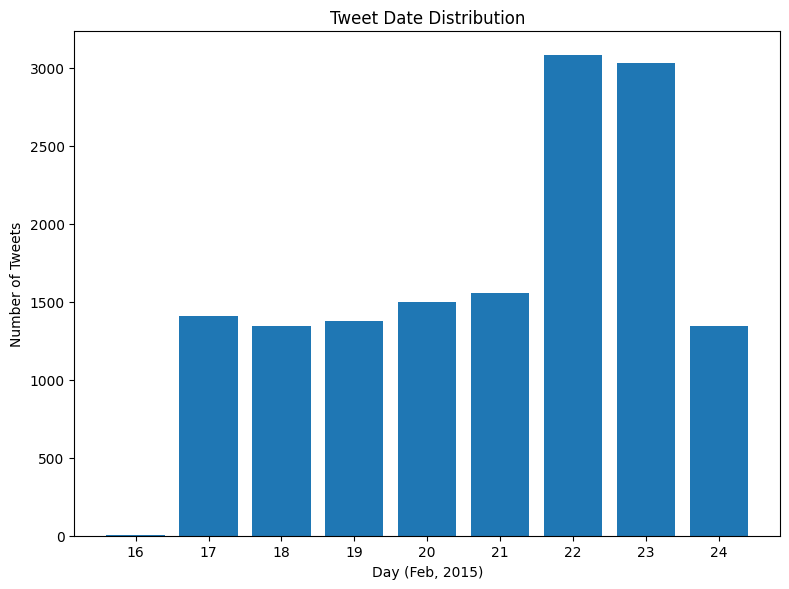

In [31]:
df['tweet_created'] = df['tweet_created'].map(pd.to_datetime)
d = df['tweet_created'].groupby(by=[df["tweet_created"].dt.month, df["tweet_created"].dt.day]).count()
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.bar([i[1] for i in d.index], d.values)
ax.set_title("Tweet Date Distribution")
ax.set_xlabel("Day (Feb, 2015)")
ax.set_ylabel("Number of Tweets")
ax.set_xticks(range(16, 25))
plt.tight_layout()

The tweets are from 16-24 of February, 2015. On Feb 22 and 23, there is a notable spike in the number of tweets. Aside from Chinese New Years on Feb 19, there weren't any holidays or notable news events at this time. 

The spike in the number of tweets might be explained by the fact that 21 and 22 are weekends (Sat, Sun). A greater number of people may have traveled during the weekends (21, 22) and then posted about their experience the day after (22, 23).

## Sentiment Analysis

We group together the different tweets according to which of 6 main airlines they mention, and perform sentiment analysis on each group.

We use `SentimentIntensityAnalyzer`, which takes in full sentences. We use the original, uncleaned text for this.

In [20]:
!pip -q install vaderSentiment

You should consider upgrading via the '/Users/TL/.pyenv/versions/3.8.5/bin/python -m pip install --upgrade pip' command.


In [32]:
# Import VADER model
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [33]:
text_cols = ['text', 'text_context', 'text_word']
text_cols + ['neg', 'neu', 'pos', 'compound']

['text', 'text_context', 'text_word', 'neg', 'neu', 'pos', 'compound']

In [34]:
text_cols = ['text', 'text_context', 'text_word']
sentiment_df = pd.DataFrame(columns = text_cols + ['neg', 'neu', 'pos', 'compound'])

for i, row in df.iterrows():
    res = sia.polarity_scores(row['text'])
    text_values = {col: row[col] for col in text_cols}
    sentiment_df = sentiment_df.append({**text_values, **res}, ignore_index=True)

In [35]:
sentiment_df

,text,text_context,text_word,neg,neu,pos,compound
0,@VirginAmerica What @dhepburn said.,What said.,said,0.000,1.000,0.000,0.0000
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,plus youve added commercial experience tacky,0.000,1.000,0.000,0.0000
2,@VirginAmerica I didn't today... Must mean I n...,I didnt today... Must mean I need to take anot...,didnt today must mean need take another trip,0.000,1.000,0.000,0.0000
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,really aggressive blast obnoxious entertainmen...,0.226,0.645,0.129,-0.2716
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,really big bad thing,0.296,0.704,0.000,-0.5829
...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,thank you we got on a different flight to Chic...,thank got different flight chicago,0.000,0.800,0.200,0.3612
14636,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes Late Flight. No warnin...,leaving 20 minute late flight warning communic...,0.136,0.793,0.071,-0.4043
14637,@AmericanAir Please bring American Airlines to...,Please bring American Airlines to,please bring american airline,0.000,0.723,0.277,0.3182
14638,"@AmericanAir you have my money, you change my ...","you have my money, you change my flight, and d...",money change flight dont answer phone suggesti...,0.000,0.871,0.129,0.5027


In [36]:
sentiment_df = pd.DataFrame(columns=['text', 'text_context', 'text_word', 'neg', 'neu', 'pos', 'compound'])

for text in df['text']:
    res = sia.polarity_scores(text)
    sentiment_df = sentiment_df.append({'text': text, **res}, ignore_index=True)
sentiment_df

,text,text_context,text_word,neg,neu,pos,compound
0,@VirginAmerica What @dhepburn said.,NaN,NaN,0.000,1.000,0.000,0.0000
1,@VirginAmerica plus you've added commercials t...,NaN,NaN,0.000,1.000,0.000,0.0000
2,@VirginAmerica I didn't today... Must mean I n...,NaN,NaN,0.000,1.000,0.000,0.0000
3,@VirginAmerica it's really aggressive to blast...,NaN,NaN,0.226,0.645,0.129,-0.2716
4,@VirginAmerica and it's a really big bad thing...,NaN,NaN,0.296,0.704,0.000,-0.5829
...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,NaN,NaN,0.000,0.800,0.200,0.3612
14636,@AmericanAir leaving over 20 minutes Late Flig...,NaN,NaN,0.136,0.793,0.071,-0.4043
14637,@AmericanAir Please bring American Airlines to...,NaN,NaN,0.000,0.723,0.277,0.3182
14638,"@AmericanAir you have my money, you change my ...",NaN,NaN,0.000,0.871,0.129,0.5027


## Average sentiment for the entire dataset:

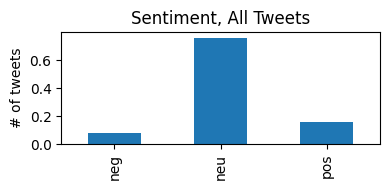

In [37]:
fig = plt.figure(dpi=100)
ave_sentiment_scores_all = sentiment_df[['neg', 'neu', 'pos']].sum(axis=0) / sentiment_df.shape[0]
ave_sentiment_scores_all.plot.bar(title='Sentiment, All Tweets', ylabel='# of tweets', figsize=(4, 2))
plt.tight_layout()
plt.show()

## Ave sentiment for each airline:

In [39]:
# Group the tweets together according to airline
# Note: This approach isn't perfect
# It may fail to classify correctly a tweet which mentions multiple airlines

tweets_by_airline = {k:pd.DataFrame(columns=sentiment_df.columns) for k in airlines.keys()}

for i, row in sentiment_df.iterrows():
    tweet = row['text']
    for airline in airlines:
        if airline in tweet.lower():
            tweets_by_airline[airline] = tweets_by_airline[airline].append(row)
            break

In [40]:
airline_scores_ave = {}
for airline, df_ in tweets_by_airline.items():
    scores = df_[['neg', 'neu', 'pos']]
    airline_scores_ave[airline] = scores.sum(axis=0) / df_.shape[0]

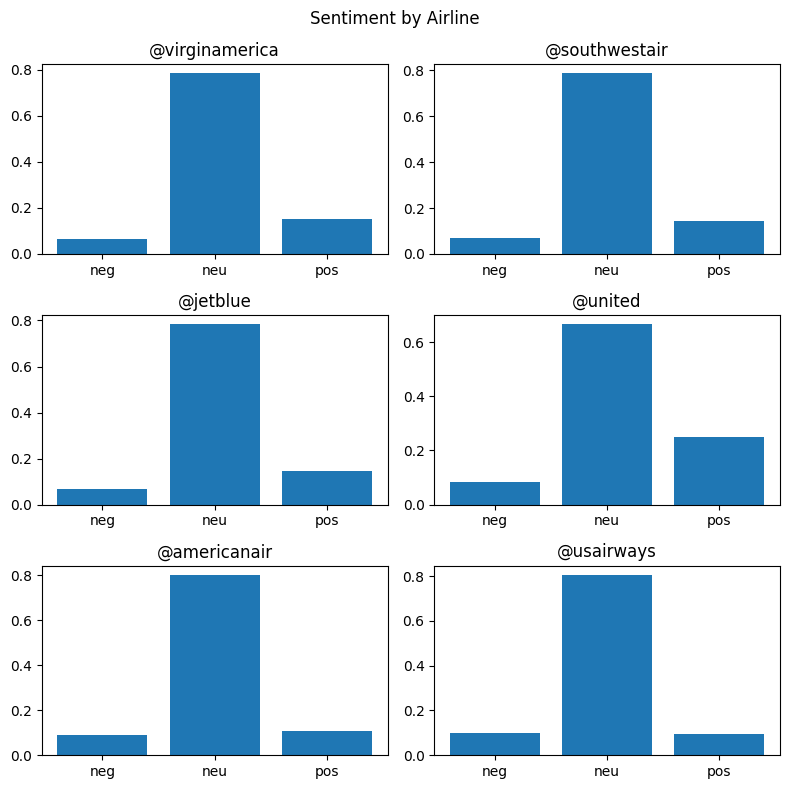

In [41]:
nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8), dpi=100)
for airline_scores, ax in list(zip(airline_scores_ave.items(), fig.axes)):
    airline, scores = airline_scores
    ax.set_title(airline)
    
    d = dict(scores)
    ax.bar(*zip(*d.items()))

fig.suptitle("Sentiment by Airline")
plt.tight_layout()
plt.show()

Surprisingly enough, the sentiment for each airline is generally more positive than negative (with the sole exception being for US Airways. Given the amount of airline-related horror stories I've heard, I would have expected more negative sentiment from the tweets.

Now that I know the general sentiment for each airline, I want to know the reason for those sentiments. What is it that people usually like/hate about their experience? We find this out by creating word clouds.

## Airline Rankings

Airlines ranked by compound sentiment score.

In [44]:
airline_scores_ave

{'@virginamerica': neg    0.062841
 neu    0.784773
 pos    0.152391
 dtype: float64,
 '@southwestair': neg    0.068952
 neu    0.786394
 pos    0.144658
 dtype: float64,
 '@jetblue': neg    0.067315
 neu    0.784566
 pos    0.148117
 dtype: float64,
 '@united': neg    0.082973
 neu    0.666946
 pos    0.250079
 dtype: float64,
 '@americanair': neg    0.089144
 neu    0.801488
 pos    0.109366
 dtype: float64,
 '@usairways': neg    0.098557
 neu    0.806340
 pos    0.095099
 dtype: float64}

In [48]:
ave_compound_scores = {}
for airline, df_ in tweets_by_airline.items():
    ave_compound_scores[airline] = df_['compound'].sum()/df_.shape[0]

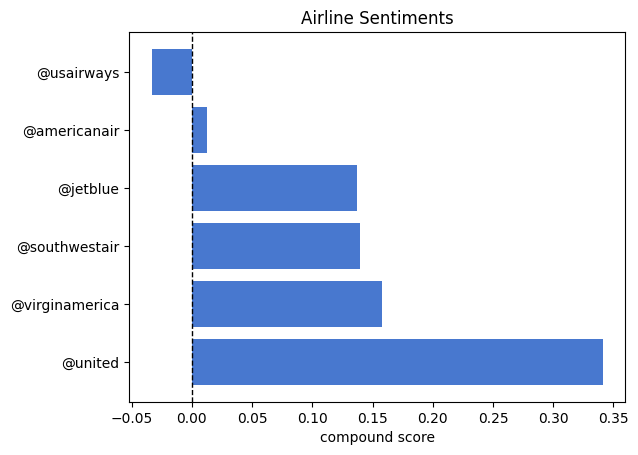

In [49]:
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(dpi=100)

airlines_sorted = sorted(list(ave_compound_scores.items()), key=lambda x: x[1])

# Example data
airlines = [a[0] for a in airlines_sorted]
y_pos = range(len(airlines_sorted))
performance = [a[1] for a in airlines_sorted]
ax.barh(y_pos, performance,  align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(airlines)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('compound score')
ax.set_title('Airline Sentiments')
plt.axvline(x=0, c='black', lw=1, ls='--')

plt.show()

* US Airways is the most disliked - the only airline with a negative score.
* American Air also has a relatively low score.
* United Airlines is by far the most liked, with more than twice the score of the 2nd placed Virgin America.

## Identifying the Reason for the Sentiment Scores

To achieve the goal for this section, we will use Word Clouds and Topic Modeling.

In [ ]:
!pip -q install seaborn wordcloud
from wordcloud import WordCloud

In [ ]:
def create_wordcloud(ax, tweets: Iterable[str], max_words: int=500, title: str=""):
    """Create a wordcloud of most common words in a set of tweets"""
    
    # Transform text for WordCloud
    tweets = ' '.join(tweets)
    tweets = tweets.replace(' ', ',')
    
    # Generate wordcloud image
    wc = WordCloud(width=1200, height=1200, background_color="white", 
                   max_words=max_words)
    wc.generate(tweets)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, size=20)
    


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=200)
for airline, ax in zip(tweets_by_airline.keys(), fig.axes):
    create_wordcloud(ax, tweets_by_airline[airline]['text_word'], max_words=200, title=airline)
    ax.axis("off")

So far, there really isn't anything unexpected from these word clouds. We see common air travel terms such as `flight`, `delay`, `cancelled`, etc.

The word `thank` shows up a lot. This supports the sentiment analysis results, which show higher positive sentiment. It seems that people like tweeting about their positive experiences and then thanking the airline. Another reason that it shows up so much is that peope usually end a question with "thanks!".

In [ ]:
for t in sentiment_df[sentiment_df['text_word'].map(lambda x: 'thank' in x)]['text'].iloc[:5]:
    print(t)

## Word Frequency
To fulfill the same purpose as the word cloud earlier, we also create word frequency graphs.

In [ ]:
word_frequency = {}
for i, row in df.iterrows():
    for word in row['text_word'].split():
        word_frequency[word] = word_frequency.get(word, 0) + 1
        
# Get sorted list
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
# Keep only top 10 words
word_frequency = word_frequency[:10]

In [ ]:
word_frequency
keys, items = zip(*word_frequency)
print(keys)
print(items)

In [ ]:
keys, items = zip(*word_frequency)


fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.bar(keys, items)
ax.set_title("Word Frequency, All")
plt.tight_layout()

Again, there seems to be nothing unusual here. It is natural that most tweets on airlines will mention a flight.
The 6th most mentioned word `u` is just a shortening of `you`.

So far, I still haven't fulfilled my goal of finding out the reasons why people might like or dislike a particular airline. To achieve this, it might be useful to group tweets into either positive or negative, and then get the word frequencies for each group. For this, we will say that any tweets with `compound > 0` is positive, and `compound < 0` is negative. Those with `compound == 0` are considered neutral and will be ignored.

In [ ]:
positive_tweets = []
negative_tweets = []

for i, row in sentiment_df.iterrows():
    if row['compound'] > 0:
        positive_tweets.append(row['text_word'])
    elif row['compound'] < 0:
        negative_tweets.append(row['text_word'])
    else:
        continue

In [ ]:
def word_count_list(corpus: List['str']) -> "word freq dict":
    word_freq = {}
    for text in corpus:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1
    return word_freq

pos_words_freq = word_count_list(positive_tweets)
neg_words_freq = word_count_list(negative_tweets)

# Keep only the top 10 words
pos_words_freq = sorted(pos_words_freq.items(), key=lambda x: x[1], reverse=True)[:10]
neg_words_freq = sorted(neg_words_freq.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# Reverse lists again for horizontal bar graph
word_freq_lists = [pos_words_freq[::-1], neg_words_freq[::-1]]
titles = ["Positive Tweets Word Frequency", "Negative Tweets Word Frequency"]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), dpi=100)

for ax, word_freq_dict, title in zip(fig.axes, word_freq_lists, titles):
    
    keys, values = zip(*word_freq_dict)
    ax.barh(keys, values)
    ax.set_title(title)

#### Positive Tweets
The positive tweets are generally those thanking the airline for a good experience, or for good customer service.

#### Negative Tweets
Negative tweets are generally about cancelled or delayed flights.

A very unusual word is `flightled`. It happens too often to be a typo, and it is found on tweets for Virgin America. I could find no information on it online, especially since Virgin America Airlines does not exist anymore. I have to assume it is some kind of flight deal or business parlance that Virgin America used.


In [ ]:
flightled = df[df['text_word'].map(lambda x: "flightled" in x)]
for text in flightled['text'].iloc[:10]:
    print(text)

## Topic Modeling

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis, pyLDAvis.gensim_models
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
split_texts = []

for text in df['text_context'].iloc[:5]:
    doc = nlp(text)
    split_text = [token.text for token in doc]
    split_texts.append(split_text)

In [ ]:
split_texts

# Findings, Summary
* The dataset contains tweets towards 6 major airlines: **US Airways, American Air, Jet Blue, Southwest Air, Virgin America, & United**.
* There are more positive tweets than negative tweets, in the entire dataset.
* On a per-airline basis, **United** has the best average sentiment score, and **US Airways** has the worst -- being the only one with a negative average compound sentiment.
* Positive tweets are generally those thanking the airline for a good experience or for good customer service.
* Negative tweets are generally those complaining about cancelled or delayed flights.
